# Simple Generative Adverserial Network (GAN) for Faking Handwritten Digits.
Chen "Raphael" Liu and Nanyan "Rosalie" Zhu

This notebook belongs to this repository ["RnR-2018/BMEN4460-NB4-GAN_faking_MNIST_images"](https://github.com/RnR-2018/BMEN4460-NB4-GAN_faking_MNIST_images) and its parent repository ["RnR-2018/Deep-learning-with-PyTorch-and-GCP"](https://github.com/RnR-2018/Deep-learning-with-PyTorch-and-GCP).

This notebook is inspired by [this succinct GitHub repository](https://github.com/lyeoni/pytorch-mnist-GAN) and [this elaborate GitHub repository](https://github.com/Garima13a/MNIST_GAN), neither of which can be directly run/used due to issues with the PyTorch version of the MNIST dataset as well as some weird things with the training processes. Anyway we thank them for the resources, and we especially like the latter who walked through some nice concepts in detail.

Also, we later found [this beautiful GitHub repository](https://github.com/znxlwm/pytorch-MNIST-CelebA-GAN-DCGAN) that is, no offense, way cooler than the other two. You are encouraged to take a look.

## Import the necessary packages.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tensorflow.keras.datasets.mnist as MNIST
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import numpy as np
from matplotlib import pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Set the random seed for reproducibility.
The random seed helps to make sure that the model parameter initialization, sequence of random shuffling, and most other nondeterministic operations are kept the same each time you run this notebook.

In [2]:
torch.manual_seed(4460)
np.random.seed(4460)

### Prepare the datast. This time we will use the entire training set (N = 60k).

In [3]:
batch_size = 100

(image_MNIST_train_set, label_MNIST_train_set), (image_MNIST_test_set, label_MNIST_test_set) = MNIST.load_data()

# MNIST data is in range [0, 255] and we need to normalize them to [0, 1].
image_train_torch = torch.from_numpy(image_MNIST_test_set / 255).type(torch.FloatTensor)
label_train_torch = torch.from_numpy(label_MNIST_test_set).type(torch.LongTensor)

train_data = TensorDataset(image_train_torch, label_train_torch)
train_loader = DataLoader(train_data, batch_size = batch_size, num_workers = 0)

### Let's check our dataset loader is functioning properly by displaying a sample image.

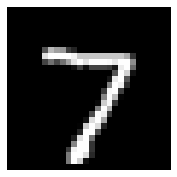

In [4]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray');
plt.axis('off');

## Define the Generator and the Discriminator.

The so-called "Generative Adverserial Networks (GAN)" is not a particular network architecture per say. It is a training strategy named "adverserial training", such that we employ a "generator" (**G**) (i.e, a fake artist) and a "discriminator" (**D**) (i.e., an FBI agent) to compete against each other. The **G** and **D** can take any form.

For now, we are using the simplest feedforward neural networks to do the job. **You can change them to convolutional neural networks if you want to have a try.**

The **G** generate images from noise (at least this is how normally generators are defined) to mimic the images provided, which in our case are the MNIST handwritten digits. The **D** is trying to distinguish which images are real and which ones are fake.

In [5]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

### Define hyperperameters and initialize the two models.

In [6]:
z_dim = batch_size
mnist_dim = image_train_torch.shape[-2] * image_train_torch.shape[-1]

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

criterion = nn.BCELoss() 

# optimizer
lr = 0.0001
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

### Isolate the training processes of D and G into standalone functions.

In [7]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    # The '0.9' is for smoothing of the ground truth label.
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(batch_size, 1) * 0.9
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on fake
    # The '0.1' is for smoothing of the ground truth label.
    z, y_fake = Variable(torch.randn(batch_size, z_dim).to(device)), torch.ones(batch_size, 1) * 0.1
    x_fake, y_fake = G(z), Variable(y_fake.to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output
    
    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

In [8]:
def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(batch_size, z_dim).to(device))
    y = Variable((torch.ones(batch_size, 1) * 0.9).to(device)) # The '0.9' is for smoothing of the ground truth label.

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

### Train the Generator and Discriminator.

In [9]:
fixed_input = Variable(torch.randn(batch_size, z_dim).to(device))
Generator_output = []

n_epoch = 50
for epoch in range(1, n_epoch + 1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):        
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

    # Use the generator on the same input every epoch to track its performance.
    Generator_output.append(G(fixed_input).cpu().detach()[0, :].reshape(28, 28))

[1/50]: loss_d: 1.236, loss_g: 0.877
[2/50]: loss_d: 1.176, loss_g: 1.281
[3/50]: loss_d: 1.454, loss_g: 0.802
[4/50]: loss_d: 1.321, loss_g: 0.790
[5/50]: loss_d: 1.313, loss_g: 0.819
[6/50]: loss_d: 1.185, loss_g: 0.987
[7/50]: loss_d: 1.146, loss_g: 1.250
[8/50]: loss_d: 1.353, loss_g: 1.950
[9/50]: loss_d: 0.967, loss_g: 1.472
[10/50]: loss_d: 1.050, loss_g: 1.286
[11/50]: loss_d: 1.216, loss_g: 1.659
[12/50]: loss_d: 0.950, loss_g: 1.405
[13/50]: loss_d: 0.862, loss_g: 1.478
[14/50]: loss_d: 1.229, loss_g: 1.630
[15/50]: loss_d: 1.101, loss_g: 1.330
[16/50]: loss_d: 0.831, loss_g: 1.374
[17/50]: loss_d: 0.890, loss_g: 1.893
[18/50]: loss_d: 1.186, loss_g: 1.393
[19/50]: loss_d: 0.912, loss_g: 1.441
[20/50]: loss_d: 0.834, loss_g: 1.656
[21/50]: loss_d: 0.975, loss_g: 1.797
[22/50]: loss_d: 0.960, loss_g: 1.814
[23/50]: loss_d: 0.856, loss_g: 1.769
[24/50]: loss_d: 0.810, loss_g: 1.927
[25/50]: loss_d: 0.835, loss_g: 1.944
[26/50]: loss_d: 0.990, loss_g: 1.653
[27/50]: loss_d: 0.91

### See how the Generator performance evolve over the 50 epochs.

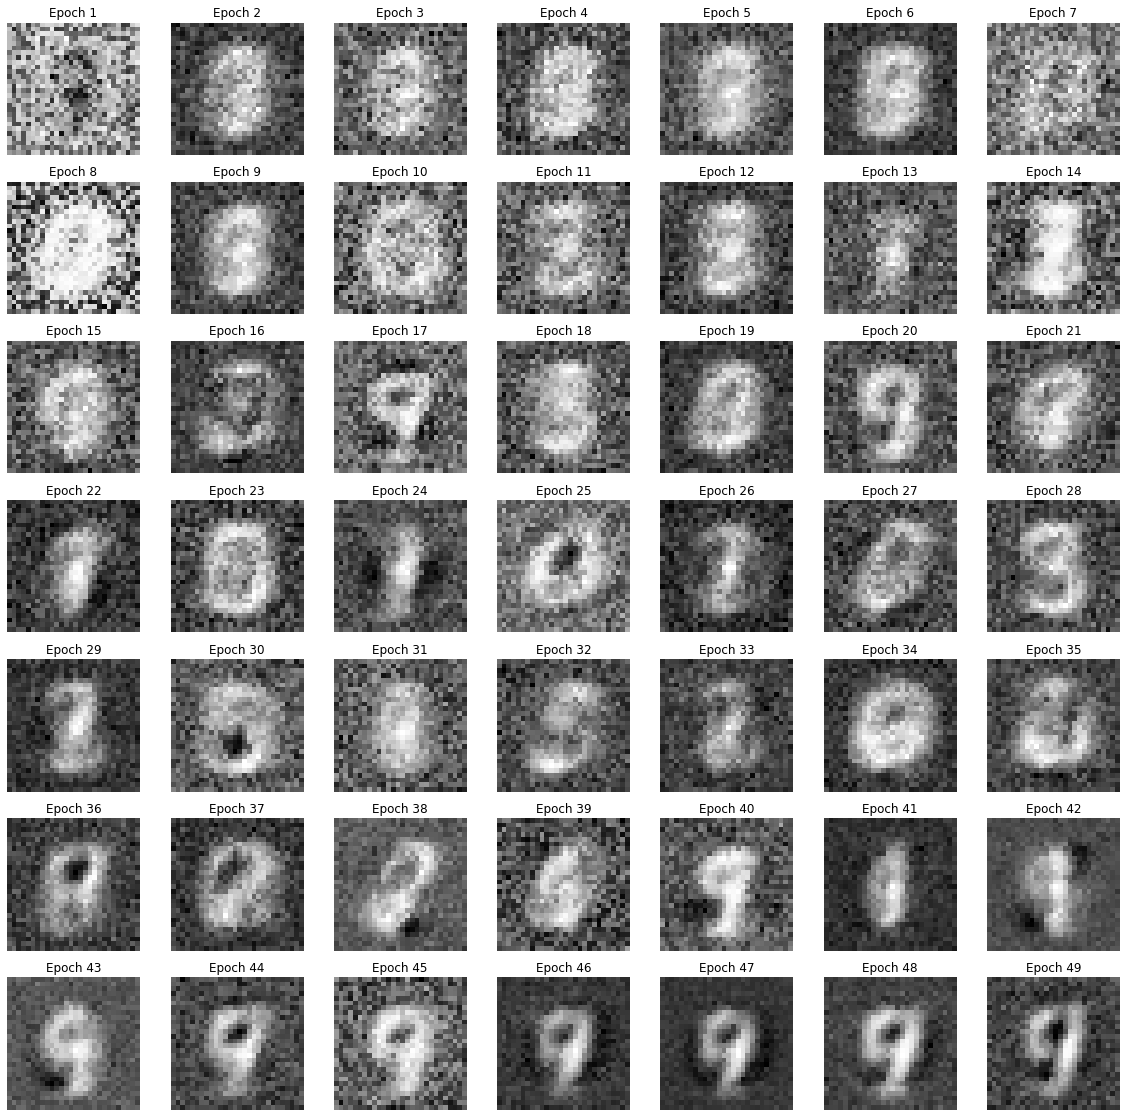

In [10]:
plt.rcParams['figure.figsize'] = [20, 20]
for epoch in range(n_epoch - 1):
    plt.subplot(7, 7, epoch + 1)
    plt.imshow(Generator_output[epoch], cmap = 'gray')
    plt.title('Epoch %d' % (epoch + 1))
    plt.axis('off')